In [1]:
# from google.colab import drive

In [2]:
# drive.mount('/content/drive/')

### Import the Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import keras
from keras.models import Sequential, Model, load_model
from keras.applications import vgg16
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input,MaxPooling2D, InputLayer,UpSampling2D, Reshape,UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array,array_to_img
import pickle
import os
import cv2
import joblib
import math

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from keras.callbacks import Callback
# from keras.utils.OneCycle import OneCycle

import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve
import seaborn as sns

In [26]:
PATH="./depth_data_GD"
folders=sorted(os.listdir(PATH))[0:15]
test_folders=sorted(os.listdir(PATH))[15:17]
print(folders)

FileNotFoundError: [Errno 2] No such file or directory: './depth_data_GD'

## Create training and Testing Data

In [6]:
training_data=[]
depth_data=[]
im_sze1=304
im_sze2=228
depth_sze1=55
depth_sze2=74



for folde in folders:
    #print(folde)
    im_list=sorted(os.listdir(os.path.join(PATH,folde)))
    #print(im_list)
    
    for img in im_list:
        #print(img)
        if 'jpg' in img:
            im_path=os.path.join(os.path.join(PATH,folde),img)
            #print(im_path)
            new_arr=cv2.imread(im_path)
            new_arr=cv2.resize(new_arr,(im_sze1,im_sze2))

            training_data.append(new_arr)
        elif 'png' in img:
            new_arr=cv2.imread(os.path.join(os.path.join(PATH,folde),img),0)
            new_arr=cv2.resize(new_arr,(depth_sze1,depth_sze2))
            depth_data.append(new_arr)
#             plt.imshow(new_arr)
#             plt.show()
            


In [7]:
test_data=[]
test_depth_data=[]
im_sze1=304
im_sze2=228
depth_sze1=55
depth_sze2=74



for folde in test_folders:
    #print(folde)
    im_list=sorted(os.listdir(os.path.join(PATH,folde)))
    #print(im_list)
    
    for img in im_list:
        #print(img)
        if 'jpg' in img:
            im_path=os.path.join(os.path.join(PATH,folde),img)
            #print(im_path)
            new_arr=cv2.imread(im_path)
            new_arr=cv2.resize(new_arr,(im_sze1,im_sze2))

            test_data.append(new_arr)
        elif 'png' in img:
            new_arr=cv2.imread(os.path.join(os.path.join(PATH,folde),img),0)
            new_arr=cv2.resize(new_arr,(depth_sze1,depth_sze2))
            test_depth_data.append(new_arr)
#             plt.imshow(new_arr)
#             plt.show()
            


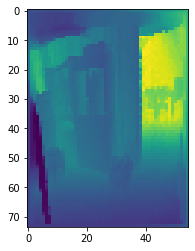

In [8]:
plt.imshow(depth_data[0])

In [10]:
depth_data_scaled=np.array(depth_data).reshape(-1,depth_sze1,depth_sze2,1).astype('float32')/255
training_data_scaled=np.array(training_data).reshape(-1,im_sze2,im_sze1,3).astype('float32')/255

In [11]:
test_depth_data_scaled=np.array(test_depth_data).reshape(-1,depth_sze1,depth_sze2,1).astype('float32')/255
test_data_scaled=np.array(test_data).reshape(-1,im_sze2,im_sze1,3).astype('float32')/255

(1476, 55, 74, 1)


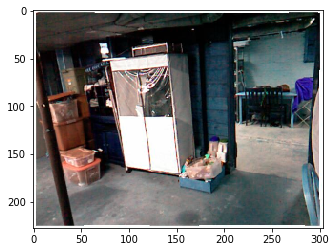

In [12]:
print(depth_data_scaled.shape)

# plt.imshow(np.reshape(depth_data[0],[depth_sze2,depth_sze1]))
# plt.show()

plt.imshow(training_data_scaled[0])
plt.show()
# plt.imshow(np.reshape(depth_data[0],[depth_sze2,depth_sze1]))
# plt.show()

### Define Custom loss functions

In [27]:
def depth_loss(y_true, y_pred):
    
#     y_true=K.cast(y_true, dtype='float32')

#     y_pred=K.cast(y_pred, dtype='float64')
#     d=K.cast(K.log(y_pred) - K.log(y_true),dtype='float64')
    
#     log_diff=K.cast(K.sum(K.square(d))/(depth_sze1*depth_sze2),dtype='float64')
#     print('boo')
#     penalty=K.square(K.sum(d))/K.cast(K.square(depth_sze1*depth_sze2),dtype='float64')

    y_true=K.cast(y_true, dtype='float32')

    y_pred=K.cast(y_pred, dtype='float32')
    
    lnYTrue = K.switch(K.equal(y_true, 0), K.zeros_like(y_true), K.log(y_true))
    #lnYPred = K.switch(K.equal(y_pred, 0), K.zeros_like(y_pred), K.log(y_pred))
    
    lnYPred=K.tf.where(K.tf.math.is_inf(y_pred), K.tf.zeros_like(y_pred), y_pred)
    
    #d=K.cast(K.log(y_pred) - K.log(y_true),dtype='float32')
    d_arr=K.cast(lnYTrue - lnYPred,dtype='float32')

    #d_arr=K.get_value(d)
    #d_arr[d_arr==-np.inf]=0
    #d_arr[d_arr==np.inf]=0
    #bools=K.equal(d, -np.inf)
    
    #print(K.eval(bools))
    
    #print(K.int_shape(bools))
    
    #d_arr = K.switch(K.equal(K.log(y_pred) - K.log(y_true), 0), K.zeros_like(K.log(y_pred) - K.log(y_true)), K.log(y_pred) - K.log(y_true))
    
    #has_inf = K.tf.constant([-np.inf, 1.,shape=(192,192,1)])
    
    #wh = K.tf.where(K.tf.equal(bools,True))
    
    #d_arr=K.tf.where(K.tf.math.is_inf(y_pred), K.tf.zeros_like(y_pred), d)
    #d_arr=K.tf.where(K.tf.is_nan(d_arr), K.tf.zeros_like(d_arr), d_arr)
    
    #print(K.eval(wh))    
    #var = K.zeros(shape=(192, 192, 1))
    #print(d_arr)
    
    #new_d=K.variable(d_arr,dtype='float32')
    #new_d=d_arr

    
    log_diff=K.cast(K.sum(K.square(d_arr))/(depth_sze1*depth_sze2),dtype='float32')
    
    print('boo')
    
    penalty=K.square(K.sum(d_arr))/K.cast(K.square(depth_sze1*depth_sze2),dtype='float32')
    
    loss=log_diff-penalty
    #print(K.eval(loss))

    return loss

In [28]:
def depth_loss3(y_true, y_pred):

#     y_true=K.cast(y_true, dtype='float32')

#     y_pred=K.cast(y_pred, dtype='float64')
#     d=K.cast(K.log(y_pred) - K.log(y_true),dtype='float64')
    
#     log_diff=K.cast(K.sum(K.square(d))/(depth_sze1*depth_sze2),dtype='float64')
#     print('boo')
#     penalty=K.square(K.sum(d))/K.cast(K.square(depth_sze1*depth_sze2),dtype='float64')

    y_true=K.cast(y_true, dtype='float32')

    y_pred=K.cast(y_pred, dtype='float32')
    
    #lnYTrue = K.switch(K.equal(y_true, 0), K.zeros_like(y_true), K.log(y_true))
    #lnYPred = K.switch(K.equal(y_pred, 0), K.zeros_like(y_pred), K.log(y_pred))
    
    lnYTrue =K.tf.where(K.tf.math.is_inf(y_true), K.tf.ones_like(y_true), y_true)
    
    lnYPred=K.tf.where(K.tf.math.is_inf(y_pred), K.tf.ones_like(y_pred), y_pred)
    
    #print(K.eval(lnYPred))
    
    #d=K.cast(K.log(y_pred) - K.log(y_true),dtype='float32')
    d_arr=K.cast(lnYTrue - lnYPred,dtype='float32')
    

    #d_arr=K.get_value(d)
    #d_arr[d_arr==-np.inf]=0
    #d_arr[d_arr==np.inf]=0
    #bools=K.equal(d, -np.inf)
    
    #print(K.eval(bools))
    
    #print(K.int_shape(bools))
    
    #d_arr = K.switch(K.equal(K.log(y_pred) - K.log(y_true), 0), K.zeros_like(K.log(y_pred) - K.log(y_true)), K.log(y_pred) - K.log(y_true))
    
    #has_inf = K.tf.constant([-np.inf, 1.,shape=(192,192,1)])
    
    #wh = K.tf.where(K.tf.equal(bools,True))
    
    #d_arr=K.tf.where(K.tf.math.is_inf(y_pred), K.tf.zeros_like(y_pred), d)
    #d_arr=K.tf.where(K.tf.is_nan(d_arr), K.tf.zeros_like(d_arr), d_arr)
    
    #print(K.eval(wh))    
    #var = K.zeros(shape=(192, 192, 1))
    #print(d_arr)
    
    #new_d=K.variable(d_arr,dtype='float32')
    #new_d=d_arr

    
    log_diff=K.cast(K.sum(K.square(d_arr))/(depth_sze1*depth_sze2),dtype='float32')
    
    print('boo')
    
    penalty=K.square(K.sum(d_arr))/K.cast(K.square(depth_sze1*depth_sze2),dtype='float32')
    
    loss=log_diff+penalty
    #print(K.eval(loss))

    return loss

In [29]:
def depth_loss2(y_true, y_pred):

    
#     y_true=K.cast(y_true, dtype='float32')

#     y_pred=K.cast(y_pred, dtype='float64')
#     d=K.cast(K.log(y_pred) - K.log(y_true),dtype='float64')
    
#     log_diff=K.cast(K.sum(K.square(d))/(depth_sze1*depth_sze2),dtype='float64')
#     print('boo')
#     penalty=K.square(K.sum(d))/K.cast(K.square(depth_sze1*depth_sze2),dtype='float64')

    y_true=K.cast(y_true, dtype='float32')

    y_pred=K.cast(y_pred, dtype='float32')
    d=K.cast((y_pred - y_true),dtype='float32')
    

    #d_arr=K.get_value(d)
    #d_arr[d_arr==-np.inf]=0
    #d_arr[d_arr==np.inf]=0
    bools=K.equal(d, -np.inf)
    
    #print(K.eval(bools))
    
    #print(K.int_shape(bools))
    #has_inf = K.tf.constant([-np.inf, 1.,shape=(192,192,1)])
    #wh = K.tf.where(K.tf.equal(bools,True))
    
    #lnYTrue = K.switch(KB.equal(d, 0), KB.zeros_like(d), KB.log(d))
    #d_arr = K.switch(KB.equal(d, 0), KB.zeros_like(d), KB.log(d))
    #d_arr=K.tf.where(K.tf.math.is_inf(d), K.tf.zeros_like(d), d)
    
    #d_arr=K.tf.where(K.tf.is_nan(d_arr), K.tf.zeros_like(d_arr), d_arr)
    
    #print(K.eval(wh))    
    #var = K.zeros(shape=(192, 192, 1))
    #print(d_arr)
    
    #new_d=K.variable(d_arr,dtype='float32')
    #new_d=d_arr

    log_diff=K.cast(K.sum(K.square(d_arr))/(depth_sze1*depth_sze2),dtype='float32')
    
    print('boo')
    
    penalty=K.square(K.sum(d_arr))/K.cast(K.square(depth_sze1*depth_sze2),dtype='float32')
    
    loss=log_diff-penalty
    #print(K.eval(loss))

    return loss

### Testing the created loss function

In [30]:
y_true = np.random.rand(57,76)
y_pred = np.random.rand(57,76)
y_pred.shape,y_true.shape


print(K.eval(depth_loss3(y_true, y_pred)))

AttributeError: module 'tensorflow.math' has no attribute 'is_inf'

### Making the Coarse Sequential Model

In [36]:
model=Sequential()

model.add(Conv2D(96,(11,11),strides=(4,4),input_shape=training_data_scaled.shape[1:],padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(384,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(384,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(256,(3,3),strides=(1,1),padding='same'))
# # model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation("linear"))
model.add(Dropout(0.4))

model.add(Reshape((64, 64,1)))

model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(1,(74,55),padding='valid'))
model.add(BatchNormalization())
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 57, 76, 96)        34944     
_________________________________________________________________
batch_normalization_11 (Batc (None, 57, 76, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 57, 76, 96)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 38, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 38, 256)       614656    
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 38, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 38, 256)       0         
__________

In [37]:
parallel_model=multi_gpu_model(model,gpus=2)

parallel_model.compile(loss=depth_loss3, optimizer=optimizers.RMSprop(lr=1e-3),metrics=[depth_loss3])
histroy=parallel_model.fit(training_data_scaled,depth_data_scaled,batch_size=32,epochs=20, validation_split=0.1)

boo
boo
Train on 1328 samples, validate on 148 samples
Epoch 1/20
1328/1328 [==============================] - 16s 12ms/step - loss: 58.4019 - depth_loss3: 58.4019 - val_loss: 175.0677 - val_depth_loss3: 175.0677
Epoch 2/20
1328/1328 [==============================] - 8s 6ms/step - loss: 41.7253 - depth_loss3: 41.7253 - val_loss: 237.2015 - val_depth_loss3: 237.2015
Epoch 3/20
1328/1328 [==============================] - 7s 5ms/step - loss: 30.2943 - depth_loss3: 30.2943 - val_loss: 224.6244 - val_depth_loss3: 224.6244
Epoch 4/20
1328/1328 [==============================] - 7s 5ms/step - loss: 22.3744 - depth_loss3: 22.3744 - val_loss: 219.0942 - val_depth_loss3: 219.0942
Epoch 5/20
1328/1328 [==============================] - 7s 5ms/step - loss: 17.4046 - depth_loss3: 17.4046 - val_loss: 52.5806 - val_depth_loss3: 52.5806
Epoch 6/20
1328/1328 [==============================] - 7s 5ms/step - loss: 14.8895 - depth_loss3: 14.8895 - val_loss: 67.6807 - val_depth_loss3: 67.6807
Epoch 7/20


### Actual Image and ground Truth

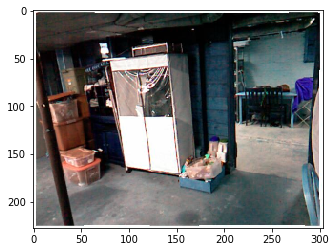

(55, 74)


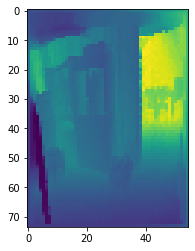

In [41]:
# print(training_data[0,:].shape)
# print(np.reshape(training_data[0,:],[im_sze1,im_sze2,3]).shape)
plt.imshow(training_data[0])
plt.show()

print(np.reshape(depth_data[0],[depth_sze1,depth_sze2]).shape)
# plt.imshow(np.reshape(depth_data[0],[depth_sze2,depth_sze1]))
plt.imshow(depth_data[0])

plt.show()


In [46]:
y_pred_prob=parallel_model.predict(np.reshape(training_data[0]/255,[-1,im_sze2,im_sze1,3]))
y_pred_prob.shape
np.reshape(y_pred_prob,[depth_sze2,depth_sze1]).shape

(74, 55)

### Predicted Coarse Image

(74, 55)


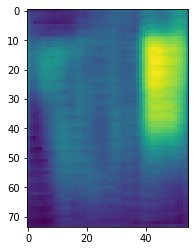

In [47]:
print(np.reshape(y_pred_prob*255,[depth_sze2,depth_sze1]).shape)
plt.imshow(np.reshape(y_pred_prob*255,[depth_sze2,depth_sze1]))
plt.show()

#### Sample Prediction on Training Dataset

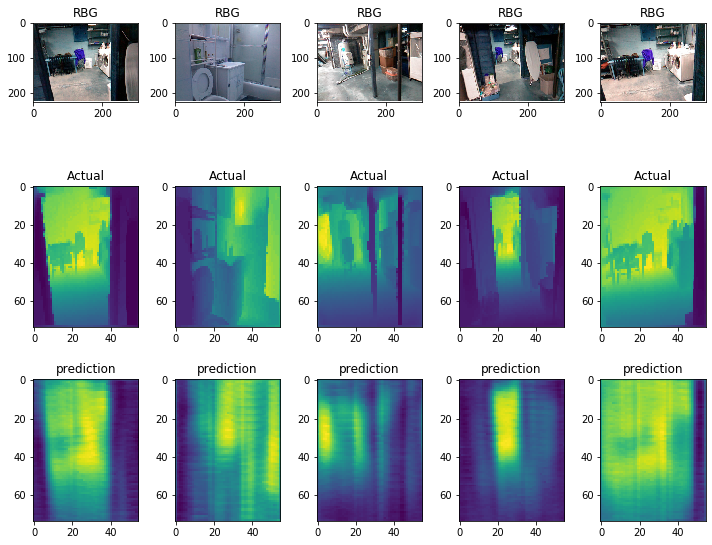

In [48]:
f = plt.figure(figsize=(10,8))
i=1
num_select=5

select=np.random.choice(len(training_data), num_select, replace=False)
for i in range(1,num_select+1):
    
    ax1=plt.subplot(3, num_select, i)
    ax1.imshow(training_data[select[i-1]])
    ax1.set_title('RBG')
    
    ax2=plt.subplot(3, num_select, i+num_select)
    ax2.imshow(depth_data[select[i-1]])
    ax2.set_title('Actual')
    
    y_pred_prob=parallel_model.predict(np.reshape(training_data[select[i-1]]/255,[-1,im_sze2,im_sze1,3]))
    ax3=plt.subplot(3, num_select, i+2*num_select)
    ax3.imshow(np.reshape(y_pred_prob,[depth_sze2,depth_sze1]))
    ax3.set_title('prediction')
    #i=i+1
plt.tight_layout()
plt.show()

## Coarse Functional Model

In [49]:
first_layer=Input(training_data_scaled.shape[1:])
conv1=Conv2D(96,(11,11),strides=(4,4),activation='relu',padding='same')(first_layer)
b1=BatchNormalization()(conv1)
p1=MaxPooling2D(pool_size=(2,2))(b1)

conv2=Conv2D(256,(5,5),activation='relu',padding='same')(p1)
b2=BatchNormalization()(conv2)
p2=MaxPooling2D(pool_size=(2,2))(b2)

conv3=Conv2D(384,(3,3),activation='relu',padding='same')(p2)
b3=BatchNormalization()(conv3)

conv4=Conv2D(384,(3,3),activation='relu',padding='same')(b3)
b4=BatchNormalization()(conv4)

Dlayer1=Dense(256,activation='relu')(b4)
b5=BatchNormalization()(Dlayer1)
p5=MaxPooling2D(pool_size=(2,2))(b5)

flat=Flatten()(p5)
flat=Dense(4096,activation='linear')(flat)
flat=BatchNormalization()(flat)
flat=Dropout(0.4)(flat)

mat=Reshape((64,64,1))(flat)

upsamp=UpSampling2D((2,2))(mat)

out1=Conv2D(1,(74,55))(upsamp)
out1=BatchNormalization()(out1)
# model.add(Flatten())
# model.add(Dense(4096))
# model.add(BatchNormalization())
# model.add(Activation("linear"))
# model.add(Dropout(0.4))

# model.add(Reshape((64, 64,1)))

# model.add(UpSampling2D(size=(2,2)))
# model.add(Conv2D(1,(74,55),padding='valid'))
model1=Model(inputs=first_layer,outputs=out1)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 228, 304, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 57, 76, 96)        34944     
_________________________________________________________________
batch_normalization_18 (Batc (None, 57, 76, 96)        384       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 38, 96)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 38, 256)       614656    
_________________________________________________________________
batch_normalization_19 (Batc (None, 28, 38, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 19, 256)       0         
__________

In [50]:
# print(depth_data_scaled[0][:,:,0].shape)
# plt.imshow(depth_data_scaled[0][:,:,0])

model1.output

<tf.Tensor 'batch_normalization_24/cond/Merge:0' shape=(?, 55, 74, 1) dtype=float32>

In [51]:
parallel_model2=multi_gpu_model(model1,gpus=2)

parallel_model2.compile(loss=depth_loss3, optimizer=optimizers.RMSprop(lr=1e-3),metrics=[depth_loss3])
histroy=parallel_model2.fit(training_data_scaled,depth_data_scaled,batch_size=32,epochs=30, validation_split=0.1)

boo
boo
Train on 1328 samples, validate on 148 samples
Epoch 1/30
1328/1328 [==============================] - 12s 9ms/step - loss: 58.5409 - depth_loss3: 58.5409 - val_loss: 339.6501 - val_depth_loss3: 339.6501
Epoch 2/30
1328/1328 [==============================] - 7s 5ms/step - loss: 41.8850 - depth_loss3: 41.8850 - val_loss: 749.4695 - val_depth_loss3: 749.4695
Epoch 3/30
1328/1328 [==============================] - 7s 5ms/step - loss: 30.1996 - depth_loss3: 30.1996 - val_loss: 135.5185 - val_depth_loss3: 135.5185
Epoch 4/30
1328/1328 [==============================] - 7s 5ms/step - loss: 22.3063 - depth_loss3: 22.3063 - val_loss: 186.8483 - val_depth_loss3: 186.8483
Epoch 5/30
1328/1328 [==============================] - 7s 5ms/step - loss: 17.4000 - depth_loss3: 17.4000 - val_loss: 148.7182 - val_depth_loss3: 148.7182
Epoch 6/30
1328/1328 [==============================] - 7s 5ms/step - loss: 14.9231 - depth_loss3: 14.9231 - val_loss: 78.6712 - val_depth_loss3: 78.6712
Epoch 7/30

### Actual Image and ground Truth

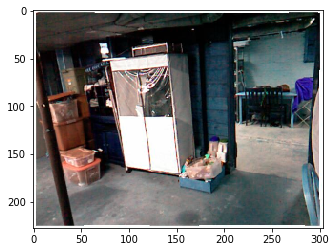

(55, 74)


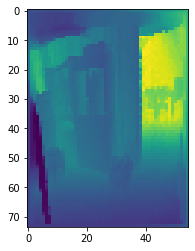

In [56]:
# print(training_data[0,:].shape)
# print(np.reshape(training_data[0,:],[im_sze1,im_sze2,3]).shape)
plt.imshow(training_data[0])
plt.show()


print(np.reshape(depth_data[0],[depth_sze1,depth_sze2]).shape)
plt.imshow(np.reshape(depth_data[0],[depth_sze2,depth_sze1]))
plt.show()


### Predicted Image from Keras Functional API

In [57]:
y_pred_prob=parallel_model2.predict(np.reshape(training_data[0],[-1,im_sze2,im_sze1,3]))

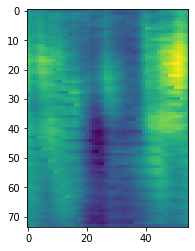

In [58]:
plt.imshow(np.reshape(y_pred_prob*255,[depth_sze2,depth_sze1]))
plt.show()

#### Sample Prediction on random examples from Training Dataset

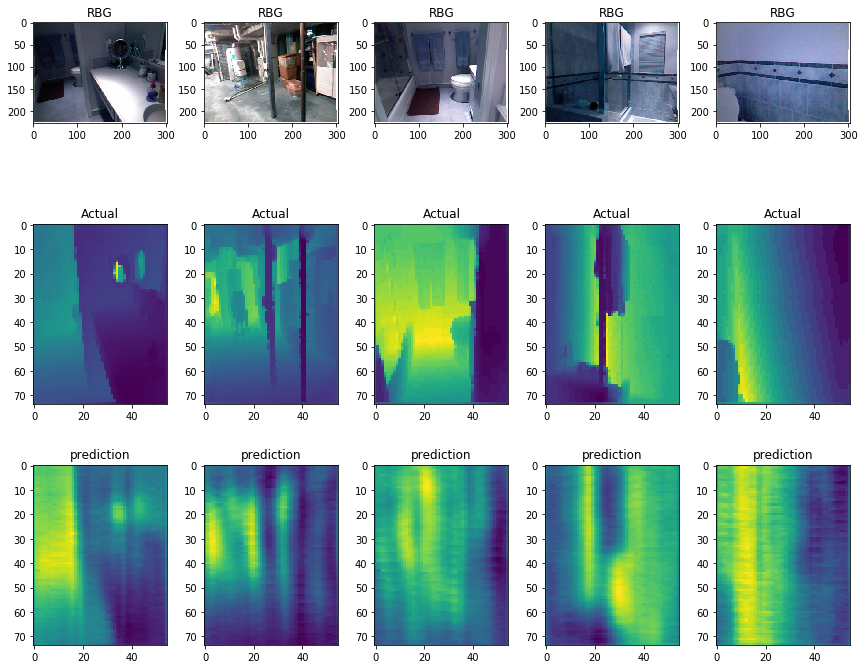

In [59]:
f = plt.figure(figsize=(12,10))
i=1
num_select=5
select=np.random.choice(len(training_data), num_select, replace=False)
for i in range(1,num_select+1):
    
    ax1=plt.subplot(3, num_select, i)
    ax1.imshow(training_data[select[i-1]])
    ax1.set_title('RBG')
    
    ax2=plt.subplot(3, num_select, i+num_select)
    ax2.imshow(depth_data[select[i-1]])
    ax2.set_title('Actual')
    
    y_pred_prob=parallel_model2.predict(np.reshape(training_data[select[i-1]]/255,[-1,im_sze2,im_sze1,3]))
    ax3=plt.subplot(3, num_select, i+2*num_select)
    ax3.imshow(np.reshape(y_pred_prob,[depth_sze2,depth_sze1]))
    ax3.set_title('prediction')
    #i=i+1
plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(training_data[select[1]])

## Making the Full Model with Coarse + Fine Tune layers

In [18]:
second_layer=Input(training_data_scaled.shape[1:])
conv21=Conv2D(63,(9,9),strides=(2,2),padding='valid')(first_layer)
b21=BatchNormalization()(conv21)
p21=MaxPooling2D(pool_size=(2,2))(b21)


Concat=concatenate([out1, p21])
# print(type(Concat),type(p21))
conv22=Conv2D(64,(5,5),padding='same')(Concat)
b22=BatchNormalization()(conv22)

out=Conv2D(1,(5,5),padding='same')(b22)
out=BatchNormalization()(out)



final_model= Model(inputs=first_layer,outputs=out)
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 228, 304, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 57, 76, 96)   34944       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 57, 76, 96)   384         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 28, 38, 96)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:


# model2=Sequential()

# model2.add(Conv2D(63,(9,9),strides=(2,2),input_shape=training_data_scaled.shape[1:],padding='valid'))
# model2.add(BatchNormalization())
# model2.add(Activation("relu"))
# model2.add(MaxPooling2D(pool_size=(2,2)))

# model2.summary()
# Concat=concatenate([model.output, model2.output])
# final_model= Model(inputs=[model.input,model2.input],outputs=Concat)


# newlayer=Input((55,74,64))
# conv1=Conv2D(64,kernel_size=2,activation='relu')(newlayer)
# conv1=BatchNormalization()(conv1)
# # conv2=Conv2D(64,kernel_size=5,activation='relu')(conv1)

# output=Conv2D(1,kernel_size=2,activation='linear')(conv1)
# # model.add(UpSampling2D(size=(2,2)))
# # model.add(Conv2D(1,(72,53),padding='valid'))

# fin=Model(inputs=model.input, outputs=output)
# """
# CONCATENATION
# model.add(Conv2D(64,(5,5),padding='same'))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))
# """


# output.summary()

In [20]:
parallel_model3=multi_gpu_model(final_model,gpus=3)

parallel_model3.compile(loss=depth_loss3, optimizer=optimizers.RMSprop(lr=1e-3),metrics=[depth_loss3])
histroy=parallel_model3.fit(training_data_scaled,depth_data_scaled,batch_size=32,epochs=30, validation_split=0.1)

boo
boo
Instructions for updating:
Use tf.cast instead.
Train on 1328 samples, validate on 148 samples
Epoch 1/30
1328/1328 [==============================] - 30s 22ms/step - loss: 58.6774 - depth_loss3: 58.6774 - val_loss: 2192.5896 - val_depth_loss3: 2192.5896
Epoch 2/30
1328/1328 [==============================] - 12s 9ms/step - loss: 42.2030 - depth_loss3: 42.2030 - val_loss: 91.6935 - val_depth_loss3: 91.6935
Epoch 3/30
1328/1328 [==============================] - 12s 9ms/step - loss: 30.5563 - depth_loss3: 30.5563 - val_loss: 536.9134 - val_depth_loss3: 536.9134
Epoch 4/30
1328/1328 [==============================] - 12s 9ms/step - loss: 22.4701 - depth_loss3: 22.4701 - val_loss: 61.6223 - val_depth_loss3: 61.6223
Epoch 5/30
1328/1328 [==============================] - 12s 9ms/step - loss: 17.6318 - depth_loss3: 17.6318 - val_loss: 76.9335 - val_depth_loss3: 76.9335
Epoch 6/30
1328/1328 [==============================] - 12s 9ms/step - loss: 15.1233 - depth_loss3: 15.1233 - val_l

### Actual Image and ground Truth

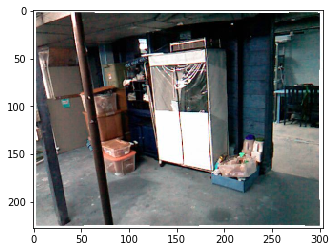

(55, 74)


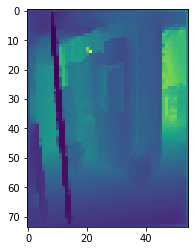

In [23]:
# print(training_data[0,:].shape)
# print(np.reshape(training_data[0,:],[im_sze1,im_sze2,3]).shape)
plt.imshow(training_data[1])
plt.show()


print(np.reshape(depth_data[1],[depth_sze1,depth_sze2]).shape)
plt.imshow(np.reshape(depth_data[1],[depth_sze2,depth_sze1]))
plt.show()


### Sample prediction of above

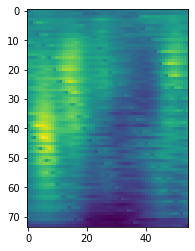

In [35]:

y_pred_prob=parallel_model3.predict(np.reshape(training_data[1],[-1,im_sze2,im_sze1,3]))
# y_pred_prob.shape
# .shape

plt.imshow(np.reshape(y_pred_prob*255,[depth_sze2,depth_sze1]))
plt.show()

### Sample predictions on radomly selected examples from training set

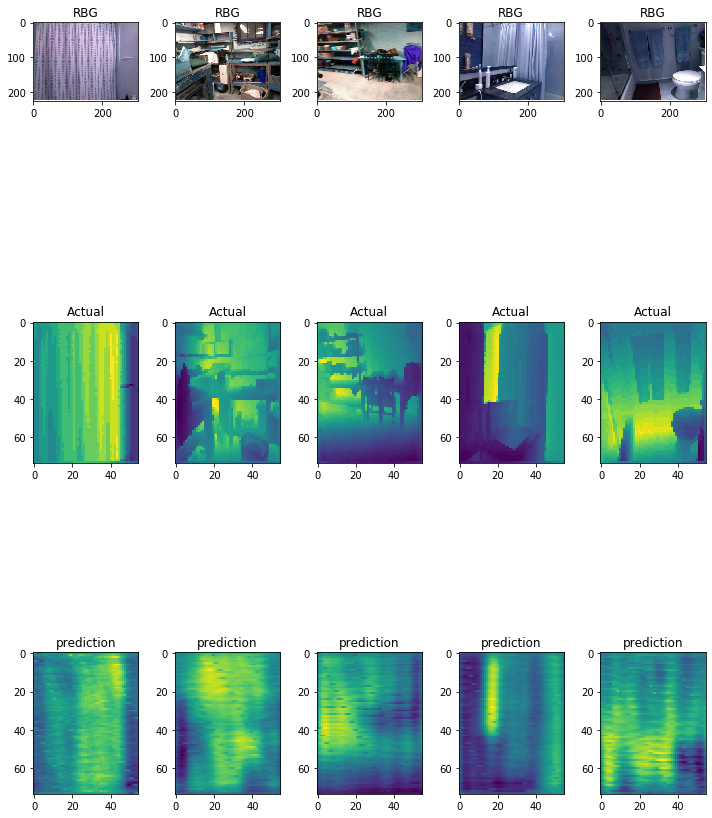

In [28]:
f = plt.figure(figsize=(10,15))
i=1
num_select=5
select=np.random.choice(len(training_data), num_select, replace=False)
for i in range(1,num_select+1):
    
    ax1=plt.subplot(3, num_select, i)
    ax1.imshow(training_data[select[i-1]])
    ax1.set_title('RBG')
    
    ax2=plt.subplot(3, num_select, i+num_select)
    ax2.imshow(depth_data[select[i-1]])
    ax2.set_title('Actual')
    
    y_pred_prob=parallel_model3.predict(np.reshape(training_data[select[i-1]]/255,[-1,im_sze2,im_sze1,3]))
    ax3=plt.subplot(3, num_select, i+2*num_select)
    ax3.imshow(np.reshape(y_pred_prob,[depth_sze2,depth_sze1]))
    ax3.set_title('prediction')
    #i=i+1
plt.tight_layout()
plt.show()

## Predicting Unseen Test Data

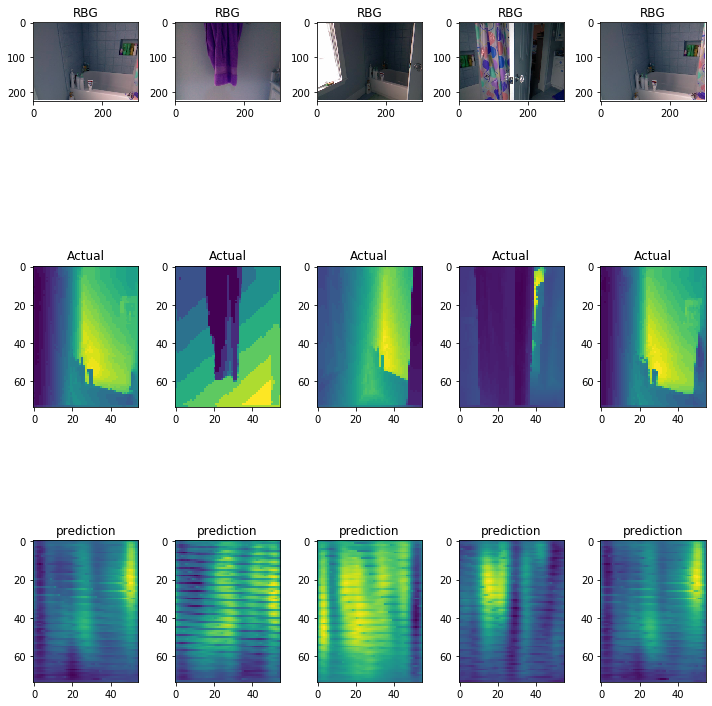

In [34]:
f = plt.figure(figsize=(10,12))
i=1
select=np.random.choice(len(test_data), 5, replace=False)
numselect=5
for i in range(1,6):
    #im1=cv2.imread(os.path.join(Datadir,'Good Parts',img1))
    #im2=cv2.imread(os.path.join(Datadir,'Defects',img2))
    
    ax1=plt.subplot(3, num_select, i)
    ax1.imshow(test_data[select[i-1]])
    ax1.set_title('RBG')
    
    ax2=plt.subplot(3, num_select, i+num_select)
    ax2.imshow(np.reshape(test_depth_data[select[i-1]],[depth_sze2,depth_sze1]))
    ax2.set_title('Actual')
    
    y_pred_prob=parallel_model3.predict(np.reshape(test_data[select[i-1]]/255,[-1,im_sze2,im_sze1,3]))
    ax3=plt.subplot(3, num_select, i+2*num_select)
    ax3.imshow(np.reshape(y_pred_prob*255,[depth_sze2,depth_sze1]))
    ax3.set_title('prediction')
    
plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(test_data[0])
plt.show()
plt.imshow(test_depth_data[0])
plt.show()

In [14]:
x=np.random.uniform(1,10,100)
type(x)

numpy.ndarray

In [13]:
type(K.cast(x,dtype='float32'))

tensorflow.python.framework.ops.Tensor